In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from IPython.display import Image
from scipy import stats
from gurobipy import Model, GRB, quicksum
%matplotlib inline

In [2]:
# settings
sns.reset_orig
sns.set_style('darkgrid')
sns.set_palette('Set1')

np.set_printoptions(linewidth=200)

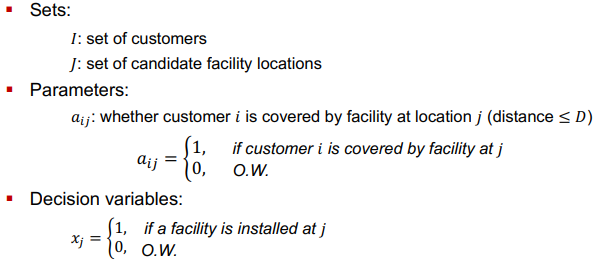

In [3]:
# display the variables
Image(filename='variables.png')

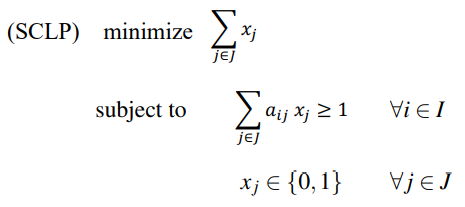

In [4]:
# display the model
Image(filename='model.png')

In [5]:
# import data
i_data = pd.read_excel('data.xlsx', sheet_name='i_data')
j_data = pd.read_excel('data.xlsx', sheet_name='j_data')
dist_ij = pd.read_excel('data.xlsx', sheet_name='dist_ij').values

In [6]:
# declare the parameters and sets
I = [i for i in range(len(i_data['X'].values))]
J = [j for j in range(len(j_data['X'].values))]
A = [(i, j) for i in I for j in J]

D = 100
a = {(i, j): int(dist_ij[i, j] <= D) for (i, j) in A}

In [7]:
# create model
mdl = Model('SCLP')

Academic license - for non-commercial use only - expires 2022-08-28
Using license file C:\Users\jack4\gurobi.lic


In [8]:
# add model variables
x = mdl.addVars(J, vtype=GRB.BINARY)

In [9]:
# add objective function
mdl.ModelSense = GRB.MINIMIZE
mdl.setObjective(quicksum(x[j] for j in J))

In [10]:
# add the model constraints
mdl.addConstrs(quicksum(a[i,j]*x[j] for j in J) >= 1 for i in I)
mdl.update()

In [11]:
%%time

# optimize
mdl.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 100 rows, 20 columns and 1062 nonzeros
Model fingerprint: 0xf503178d
Variable types: 0 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 4.0000000
Presolve removed 100 rows and 20 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 16 available processors)

Solution count 2: 3 4 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.000000000000e+00, best bound 3.000000000000e+00, gap 0.0000%
Wall time: 8.17 ms


In [12]:
# opened locations and covered customers
opened = [j for j in J if x[j].X > 0.0]

In [13]:
# update the dataframes
j_data['Opened'] = [int(x[j].X > 0.0) for j in J]

Text(0.5, 1.0, 'Facilities Chosen')

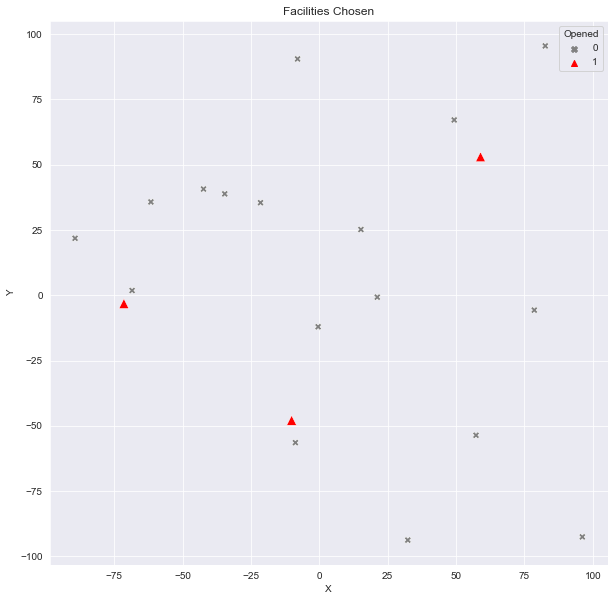

In [14]:
# plot the station locations
fig, ax = plt.subplots(figsize=(10,10))
s = [100 if i == 1 else 50 for i in j_data['Opened'].values]
sns.scatterplot(x='X', y='Y', data=j_data, hue='Opened', palette=['grey', 'red'], style='Opened', markers=('X', '^'), s=s)
plt.title('Facilities Chosen')

Text(0.5, 1.0, 'Facility Coverage')

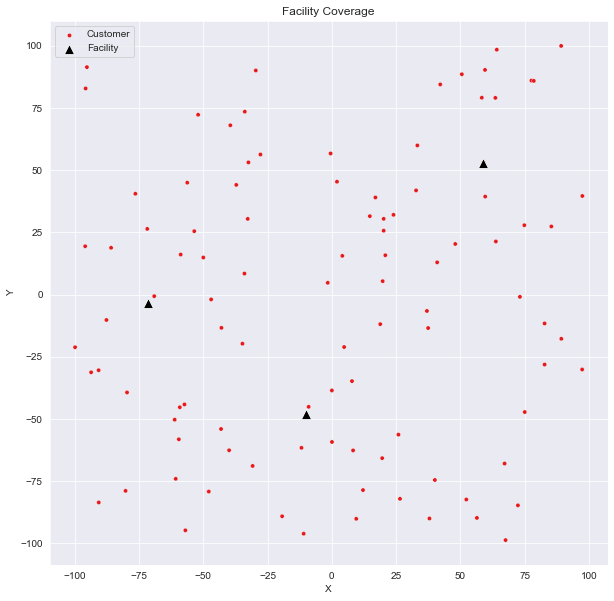

In [15]:
# plot the customer coverage
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x='X', y='Y', data=i_data, size=1, legend=False, label="Customer")
sns.scatterplot(x='X', y='Y', data=j_data[j_data['Opened'] == 1], s=100, color='black', marker='^', label="Facility")
plt.title('Facility Coverage')

In [16]:
# find objective value
obj_val = sum([int(x[j].X) for j in J])

print('Objective value = ', obj_val)

Objective value =  3
